In [1]:
# Parameters
artificial_humans = {
    "full": {
        "contribution_model": "artifacts/behavioral_cloning/21_contribution_model_v4/model/architecture_node+edge+rnn__dataset_full.pt",
        "valid_model": "artifacts/behavioral_cloning/22_contribution_valid_model_v4/model/rnn_False__dataset_full.pt",
    },
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "artifacts/behavioral_cloning/23_punishment_autoregressive_v4/model/architecture_node+edge.pt",
        "autoregressive": True,
    },
    "pgh,0.98": {
        "type": "rl",
        "path": "artifacts/manager/17_exp2_group_payoff_heavy_optimize/model/_manager.pt",
    },
}
n_episode_steps = 24
n_episodes = 100
output_dir = "../../notebooks/test_manager/simulate_group_selection/01_all_artifacts"
basedir = "../.."

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import random
from itertools import count

import numpy as np
import pandas as pd
import seaborn as sns
import torch as th

from aimanager.artificial_humans import GraphNetwork
from aimanager.manager.api_manager import MultiManager
from aimanager.manager.environment import ArtificialHumanEnv
from aimanager.manager.memory import Memory
from aimanager.utils.array_to_df import add_labels, using_multiindex
from aimanager.utils.utils import make_dir

plot_folder = output_dir

make_dir(plot_folder)

managers = {k:{**v, 'model_path': os.path.join(basedir, v['path'])} for k,v in managers.items()}
managers

{'humanlike': {'type': 'human',
  'path': 'artifacts/behavioral_cloning/23_punishment_autoregressive_v4/model/architecture_node+edge.pt',
  'autoregressive': True,
  'model_path': '../../artifacts/behavioral_cloning/23_punishment_autoregressive_v4/model/architecture_node+edge.pt'},
 'pgh,0.98': {'type': 'rl',
  'path': 'artifacts/manager/17_exp2_group_payoff_heavy_optimize/model/_manager.pt',
  'model_path': '../../artifacts/manager/17_exp2_group_payoff_heavy_optimize/model/_manager.pt'}}

In [3]:
def mem_to_df(recorder, name):
    columns = ["episode", "participant_code", "round_number"]

    punishments = using_multiindex(
        recorder.memory["punishment"].squeeze(1).numpy(),
        columns=columns,
        value_name="punishment",
    )
    common_good = using_multiindex(
        recorder.memory["common_good"].squeeze(1).numpy(),
        columns=columns,
        value_name="common_good",
    )
    contributions = using_multiindex(
        recorder.memory["contribution"].squeeze(1).numpy(),
        columns=columns,
        value_name="contribution",
    )
    group = using_multiindex(
        recorder.memory["group"].squeeze(1).numpy(), columns=columns, value_name="group"
    )

    df_sim = punishments.merge(common_good).merge(contributions).merge(group)

    df_sim["participant_code"] = (
        df_sim["participant_code"].astype(str) + "_" + df_sim["episode"].astype(str)
    )

    df_sim["run"] = name
    return df_sim


def make_round(contributions, round, groups, episode_group_idx):
    return {
        "contribution": contributions,
        "contribution_valid": [c is not None for c in contributions],
        "punishment_valid": [False] * len(contributions),
        "punishment": [None] * len(contributions),
        "group": groups,
        "round": round,
        "episode_group_idx": episode_group_idx,
    }


def add_punishments(round, punishments):
    return {
        **round,
        "punishment": punishments,
        "punishment_valid": [p is not None for p in punishments],
    }

In [4]:
# def _get_better_avg_movement_map(self):
#     avg_payoffs = [group.average_contributor_payoff for group in self.human_groups]
#     max_idx, max_avg = max(enumerate(avg_payoffs), key=itemgetter(1))
#     move_map: dict[tuple, int] = {}
#     for gid, group in enumerate(self.human_groups):
#         for aid in range(group.n_agents):
#             if group.contributor_payoff[0, aid] < max_avg:
#                 move_map[(gid, aid)] = max_idx
#             else:
#                 move_map[(gid, aid)] = gid

In [5]:
def update_groups(recorder, groups, round_number, horizon):
    new_groups = []
    for i in range(n_groups):
        if punishments[i] is not None:
            new_groups.append(groups[punishments[i]])
        else:
            new_groups.append(groups[contributions[i]])
    return new_groups

In [6]:
# round_number = 3
# horizon = 4

# contributor_payoff = recorder.memory['contributor_payoff']
# group = recorder.memory['group']
# relevant_contributor_payoff = contributor_payoff[:, :, :, round_number - horizon + 1:round_number + 1]
# relevant_group = group[:, :, round_number - horizon + 1:round_number + 1]

In [7]:
# env = ArtificialHumanEnv(
#     artifical_humans=ah,
#     artifical_humans_valid=ah_val,
#     n_agents=n_agents, n_contributions=21, n_punishments=31,
#     n_rounds=n_episode_steps, batch_size=1, n_groups=2, device=device)


# agent_groups = th.tensor([[0]*4 + [1]*4])

# env.update_groups(agent_groups)

In [8]:
def assign_group_idx(groups):
    unique_groups = list(set(groups))
    g_name_to_idx = {g: i for i, g in enumerate(unique_groups)}
    gidx_to_name = {i: g for i, g in enumerate(unique_groups)}
    return g_name_to_idx, gidx_to_name


def get_agent_groups(groups, g_name_to_idx):
    return th.tensor([[g_name_to_idx[g] for g in groups]])


def change_groups(recorder, round_number, horizon, episode, gidx_to_name):
    group_payoff = recorder.memory["group_payoff"]
    contributor_payoff = recorder.memory["contributor_payoff"]
    groups = recorder.memory["group"]

    assert group_payoff.shape[1] == 1
    assert contributor_payoff.shape[1] == 1

    avg_group_payoff = group_payoff[
        episode, 0, :, round_number - horizon + 1 : round_number + 1
    ].mean(-1)
    avg_contributor_payoff = contributor_payoff[
        episode, 0, :, round_number - horizon + 1 : round_number + 1
    ].mean(-1)
    groups = groups[episode, 0, :, round_number]

    best_group_payoff, best_group_idx = avg_group_payoff.max(-1)

    contributor_payoff_below_best = (
        avg_contributor_payoff < best_group_payoff.unsqueeze(-1)
    )

    groups = th.where(contributor_payoff_below_best, best_group_idx, groups)

    groups = [gidx_to_name[g.item()] for g in groups]

    return groups

In [9]:
device = th.device("cpu")
rec_device = th.device("cpu")

mm = MultiManager(
    managers,
    n_steps=n_episode_steps,
)

# fix bug
for k, man in mm.managers.items():
    if "autoregressive" in managers[k]:
        man.model.autoregressive = managers[k]["autoregressive"]

n_agents = 8

group_change_freq = 4

artificial_human = artificial_humans["full"]
manager = list(managers.keys())

# runs = {
#     f"managed by {m}": {'groups': [m]*n_agents, 'humans': 'full'}
#     for m in manager
# }

runs = {}
runs["mixed"] = {
    "groups": [manager[0]] * (n_agents // 2) + [manager[1]] * (n_agents // 2),
    "humans": "full",
}

dfs = []
for name, run in runs.items():
    print(f"Start run {name}")
    n_agents = len(run["groups"])
    g_name_to_idx, gidx_to_name = assign_group_idx(run["groups"])
    n_groups = len(g_name_to_idx)

    hm_path = os.path.join(
        basedir, artificial_humans[run["humans"]]["contribution_model"]
    )
    hmv_path = os.path.join(basedir, artificial_humans[run["humans"]]["valid_model"])

    ah = GraphNetwork.load(hm_path, device=device)
    ah_val = GraphNetwork.load(hmv_path, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah,
        artifical_humans_valid=ah_val,
        n_agents=n_agents,
        n_contributions=21,
        n_punishments=31,
        n_rounds=n_episode_steps,
        batch_size=1,
        n_groups=n_groups,
        device=device,
    )
    recorder = Memory(
        n_episodes=n_episodes,
        n_episode_steps=n_episode_steps,
        output_file=None,
        device=device,
    )
    for e in range(n_episodes):
        groups = run["groups"]
        state = env.reset()
        env.update_groups(get_agent_groups(groups, g_name_to_idx))
        episode_group_idx = random.randint(0, 1000000)
        rounds = []
        for round_number in count():
            contributions = state["contribution"].squeeze().tolist()
            round = make_round(contributions, round_number, groups, episode_group_idx)
            punishments = mm.get_punishments(rounds + [round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments.unsqueeze(-1).unsqueeze(0))
            recorder.add(
                **{
                    k: v if len(v.shape) == 3 else v.unsqueeze(-1)
                    for k, v in state.items()
                },
                episode_step=round_number,
            )
            state, reward, done = env.step()
            if done:
                break
            if (round_number + 1) % group_change_freq == 0:
                groups = change_groups(
                    recorder, round_number, group_change_freq, e, gidx_to_name
                )
                if not (all([g == groups[0] for g in groups])):
                    print(round_number, groups)
                env.update_groups(get_agent_groups(groups, g_name_to_idx))
        recorder.next_episode(e)
    some_df = mem_to_df(recorder, name=name)
    some_df["manager"] = some_df["group"].map(dict(enumerate(manager)))
    dfs.append(some_df)

Start run mixed
tensor([16.4500, 25.9500, 18.9500, 20.9500, 17.5250, 23.2750, 23.7750, 22.2750]) tensor(21.7125)
tensor([ True, False,  True,  True,  True, False, False, False])
3 ['pgh,0.98', 'humanlike', 'pgh,0.98', 'pgh,0.98', 'pgh,0.98', 'pgh,0.98', 'pgh,0.98', 'pgh,0.98']
tensor([25.6726,  7.7000, 21.1643, 28.6726, 20.4226, 24.4226, 25.1726, 24.1726]) tensor(25.0536)
tensor([False,  True,  True, False,  True,  True, False,  True])
tensor([28.5214, 28.0214, 36.2714, 30.0214, 23.2714, 20.9000, 27.7714, 28.0214]) tensor(28.7268)
tensor([ True,  True, False, False,  True,  True,  True,  True])
tensor([28.4500, 35.7000, 32.9500, 30.2000, 23.9500, 26.7000, 25.2000, 27.9500]) tensor(28.8875)
tensor([ True, False, False, False,  True,  True,  True,  True])
tensor([29.6000, 34.1000, 33.1000, 30.1000, 22.6000, 26.1000, 24.6000, 27.6000]) tensor(28.4750)
tensor([False, False, False, False,  True,  True,  True,  True])
tensor([27.5375, 26.7875, 33.7875, 29.7875,  7.6875,  7.1958, 12.6958, 20.

In [21]:
df = pd.concat(dfs)
df["payoff"] = 20 - df["contribution"] - df["punishment"] + df["common_good"]

In [22]:
df["episode"] = df["run"] + "__" + df["episode"].astype(str)

dfm = df.melt(
    id_vars=["episode", "round_number", "participant_code", "run", "manager", "group"],
    value_vars=["punishment", "contribution", "common_good"],
)

In [23]:
dfm

,episode,round_number,participant_code,run,manager,group,variable,value
0,mixed__0,0,0_0,mixed,humanlike,0,punishment,0.000000
1,mixed__0,1,0_0,mixed,humanlike,0,punishment,1.000000
2,mixed__0,2,0_0,mixed,humanlike,0,punishment,0.000000
3,mixed__0,3,0_0,mixed,humanlike,0,punishment,0.000000
4,mixed__0,4,0_0,mixed,"pgh,0.98",1,punishment,28.000000
...,...,...,...,...,...,...,...,...
5755,mixed__9,19,7_9,mixed,humanlike,0,common_good,19.275000
5756,mixed__9,20,7_9,mixed,humanlike,0,common_good,19.942858
5757,mixed__9,21,7_9,mixed,humanlike,0,common_good,21.900000
5758,mixed__9,22,7_9,mixed,humanlike,0,common_good,21.525000


In [24]:
df["group"] = df["group"].astype(float)

In [25]:
df_avg = df.groupby("round_number").mean(numeric_only=True).reset_index()

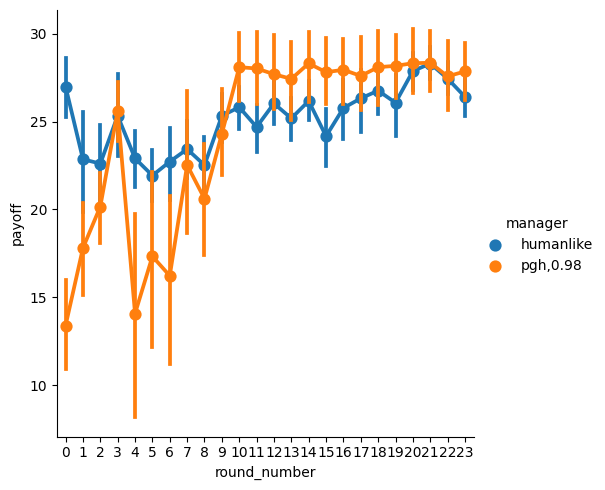

In [26]:
sns.catplot(data=df, x="round_number", y="payoff", hue="manager", kind="point")

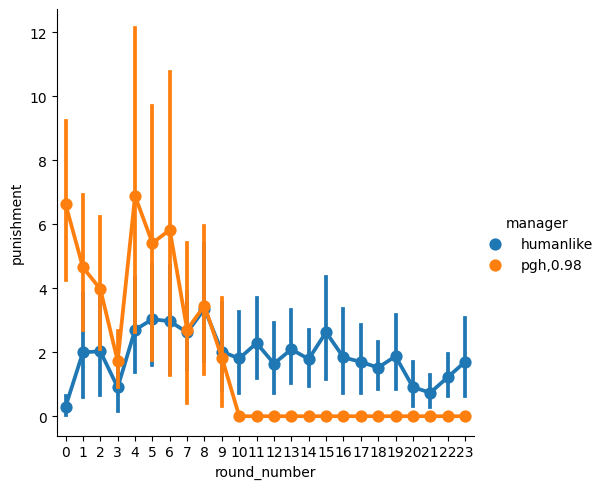

In [27]:
sns.catplot(data=df, x="round_number", y="punishment", hue="manager", kind="point")

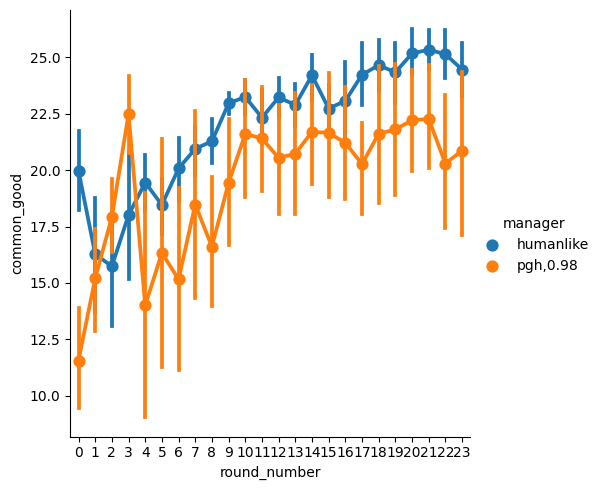

In [28]:
sns.catplot(data=df, x="round_number", y="common_good", hue="manager", kind="point")

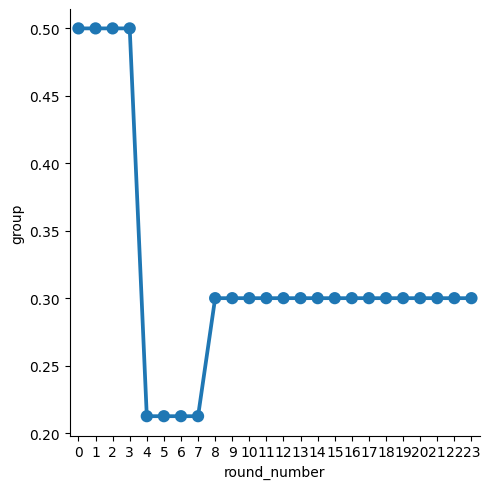

In [29]:
sns.catplot(data=df_avg, x="round_number", y="group", kind="point")

<Axes: xlabel='manager', ylabel='punishment'>

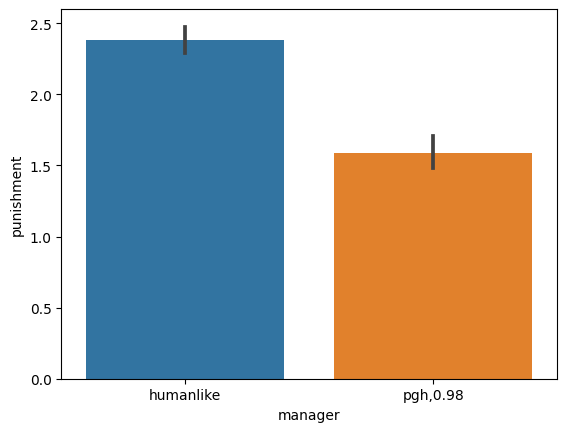

In [19]:
sns.barplot(data=df, x="manager", y="punishment")

In [20]:
recorder.memory["group"][:, 0, :, :].type(th.float).mean(1).mean(0)[::4]

tensor([0.5000, 0.3200, 0.3200, 0.3200, 0.3200, 0.3200])

In [21]:
data_file = "experiments/pilot_random1_player_round_slim.csv"
data_file = os.path.join(basedir, data_file)

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    "trail_rounds_2": "pilot human manager",
    "random_1": "pilot rule based manager",
}

df_pilot["run"] = df_pilot["experiment_name"].map(experiment_name_map)
df_pilot["common_good"] = df_pilot["common_good"] / 4
df_pilot = df_pilot[
    [
        "round_number",
        "common_good",
        "contribution",
        "participant_code",
        "punishment",
        "run",
        "global_group_id",
    ]
]

df_pilot["episode"] = df_pilot["global_group_id"]

df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

df["episode"] = df["run"] + "__" + df["episode"].astype(str)

dfm = df.melt(
    id_vars=["episode", "round_number", "participant_code", "run"],
    value_vars=["punishment", "contribution", "common_good"],
)

In [22]:
dfm

,episode,round_number,participant_code,run,variable,value
0,mixed__0,0,0_0,mixed,punishment,0.00
1,mixed__0,1,0_0,mixed,punishment,0.00
2,mixed__0,2,0_0,mixed,punishment,0.00
3,mixed__0,3,0_0,mixed,punishment,3.00
4,mixed__0,4,0_0,mixed,punishment,1.00
...,...,...,...,...,...,...
75127,pilot rule based manager__d81skd2r #7,15,kc4vb44t,pilot rule based manager,common_good,18.75
75128,pilot rule based manager__d81skd2r #8,15,abexrrr2,pilot rule based manager,common_good,-4.00
75129,pilot rule based manager__d81skd2r #10,15,pkqvc8tk,pilot rule based manager,common_good,10.75
75130,pilot rule based manager__d81skd2r #10,15,xw5jeu6y,pilot rule based manager,common_good,10.75
